In [4]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# **block-matching algorithms**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
D = []
img_paths = []
lst = []
img_paths.append(["/content/drive/MyDrive/ISLAB/EXP3/D1/img1.jpg","/content/drive/MyDrive/ISLAB/EXP3/D1/img2.jpg"])
img_paths.append(["/content/drive/MyDrive/ISLAB/EXP3/D2/img1.jpg","/content/drive/MyDrive/ISLAB/EXP3/D2/img1.jpg"])
img_paths.append(["/content/drive/MyDrive/ISLAB/EXP3/D3/img1.jpg","/content/drive/MyDrive/ISLAB/EXP3/D3/img1.jpg"])

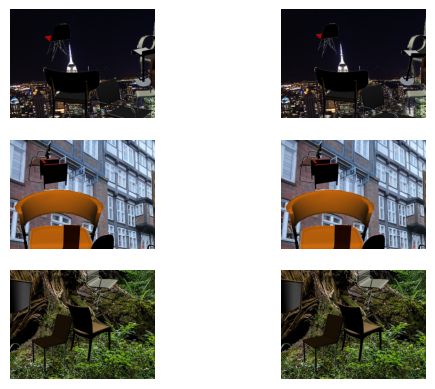

In [100]:
grayscale_transform = transforms.Grayscale()
def normalize_image(image):
    return image.astype(np.float32) / 255.0
for i in range(3):
  for j in range(2):
    image = Image.open(img_paths[i][j]).convert('RGB')
    image = normalize_image(np.array(image))
    lst.append(np.array(image))

  D.append(lst)
  lst = []

fig, axs = plt.subplots(3, 2)
for i in range(3):
    for j in range(2):
        axs[i, j].imshow(D[i][j])
        axs[i, j].axis('off')
plt.show()


In [133]:
import numpy as np
import matplotlib.pyplot as plt

def plot_motion_vectors(ref_img, motion_vectors, block_size, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Iterate over each motion vector
    for y in range(0, ref_img.shape[0], block_size):
        for x in range(0, ref_img.shape[1], block_size):
            # Get the motion vector for the current block
            motion_vector = motion_vectors[y // block_size, x // block_size]

            # Calculate the end point of the arrow
            end_point = (x + motion_vector[0], y + motion_vector[1])

            # Calculate arrow length proportional to motion vector magnitude
            arrow_length = np.sqrt(motion_vector[0] ** 2 + motion_vector[1] ** 2)

            # Draw the arrow on the reference image
            ax.arrow(x+block_size//2, y+block_size//2, motion_vector[0]+block_size//2, motion_vector[1]+block_size//2, color='r', head_width=1,
                     head_length=1)

    # Display the reference image with motion vectors
    ax.imshow(ref_img, cmap='gray')
    ax.axis('off')
    plt.show()



##Exhaustive search

In [102]:
def exhaustive_search(ref_img, cur_img, block_size):
    height, width, channels = ref_img.shape
    block_half_size = block_size // 2
    search_range = 15  # Define the search range

    # Pad images to handle blocks at the edges
    padded_ref_img = np.pad(ref_img, block_half_size, mode='constant')
    padded_cur_img = np.pad(cur_img, block_half_size, mode='constant')

    # Initialize array to store motion vectors
    motion_vectors = np.zeros((height // block_size + 1, width // block_size + 1, 2))

    # Iterate over each block
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            min_cost = float('inf')
            best_motion = [0, 0]

            # Extract block from reference image
            ref_block = padded_ref_img[i:i+block_size, j:j+block_size]

            # Iterate over search window
            for m in range(-search_range, search_range+1):
                for n in range(-search_range, search_range+1):
                    # Calculate the cost (e.g., Sum of Absolute Differences)
                    cur_block = padded_cur_img[i+m+block_half_size:i+m+block_half_size+block_size,
                                                j+n+block_half_size:j+n+block_half_size+block_size]
                    if ref_block.shape != cur_block.shape:
                      continue
                    cost = np.sum(abs(ref_block - cur_block)**2, axis=(0,1,2))

                    # Update motion vector if cost is minimized
                    if cost < min_cost:
                        min_cost = cost
                        best_motion = [m, n]

            # Store motion vector for this block
            motion_vectors[i // block_size, j // block_size] = best_motion

    return motion_vectors


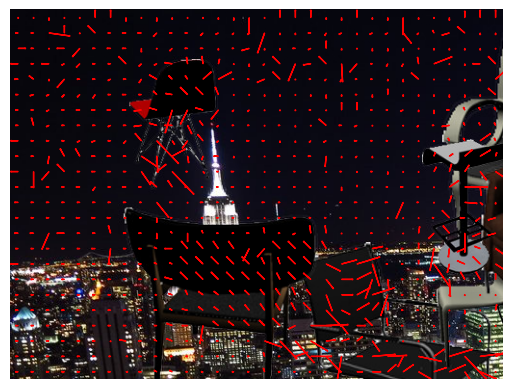

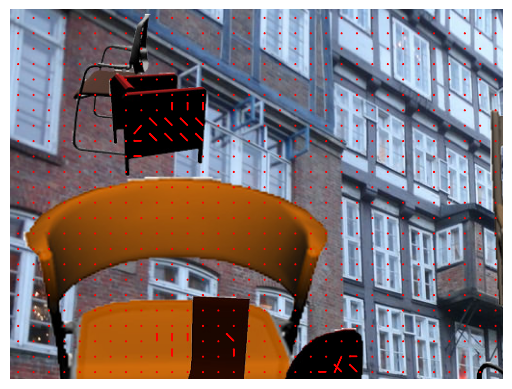

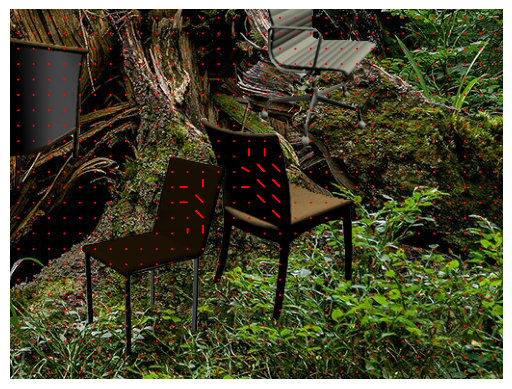

In [158]:
mvs_exts = []
for i in range(3):
  mvs_ext = exhaustive_search(D[i][0], D[i][1], 16)
  plot_motion_vectors(D[i][0], mvs_ext, 16)
  mvs_exts.append(mvs_ext)

In [140]:
gt1 = "/content/drive/MyDrive/ISLAB/EXP3/D1/GT1.npy"
gt2 = "/content/drive/MyDrive/ISLAB/EXP3/D2/GT2.npy"
gt3 = "/content/drive/MyDrive/ISLAB/EXP3/D3/GT3.npy"

gt_paths = [gt1,gt2,gt3]
gts = []

for i in range(3):
  data = np.load(gt_paths[i])
  gts.append(data)

In [144]:
def pixel_mvs(motion_vectors, block_size, ref_img):
  height, width, channels = ref_img.shape
  mvs_pix = np.zeros((height, width))

  for i in range(height):
    for j in range(width):
      mvs_pix[i][j] = abs(motion_vectors[i//block_size][j//block_size][0] + (motion_vectors[i//block_size][j//block_size][1])*1j)

  return mvs_pix


In [156]:
def normalize_array(array):
    # Find the minimum and maximum values in the array
    min_val = np.min(array)
    max_val = np.max(array)

    # Normalize the array to values between 0 and 1
    normalized_array = (array - min_val) / (max_val - min_val)

    return normalized_array

In [160]:
import matplotlib.pyplot as plt

for i in range(3):
  mvs_pix = pixel_mvs(mvs_exts[i], 16, D[i][0])
  px_arr = normalize_array(mvs_pix)
  error = np.mean(np.sqrt((px_arr - gts[i])**2))
  print(f"Mean Squared error for image {i}: {error}")

Mean Squared error for image 0: 3.732705458031844
Mean Squared error for image 1: 16.215911881248715
Mean Squared error for image 2: 28.16861352224053


##Diamond Search

In [167]:
def diamond_search(ref_img, cur_img, block_size):
    height, width, channels = ref_img.shape
    block_half_size = block_size // 2
    search_range = 4  # Define the search range

    # Pad images to handle blocks at the edges
    padded_ref_img = np.pad(ref_img, block_half_size, mode='constant')
    padded_cur_img = np.pad(cur_img, block_half_size, mode='constant')

    # Initialize array to store motion vectors
    motion_vectors = np.zeros((height // block_size, width // block_size, 2))

    # Iterate over each block
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            # Extract block from reference image
            ref_block = padded_ref_img[i:i+block_size, j:j+block_size]

            # Initialize search center
            center = [0, 0]

            # Diamond search
            step = 2
            while step >= 1:
                min_cost = float('inf')
                best_motion = [0, 0]

                # Define search pattern for diamond shape
                search_pattern = [[0, 0], [step, 0], [-step, 0], [0, step], [0, -step], [step//2, step//2], [-step//2, -step//2], [step//2, -step//2], [-step//2, step//2]]

                for m, n in search_pattern:
                    x, y = center[0] + m, center[1] + n

                    # Calculate the cost (e.g., Sum of Absolute Differences)
                    cur_block = padded_cur_img[i+x+block_half_size:i+x+block_half_size+block_size,
                                                j+y+block_half_size:j+y+block_half_size+block_size]
                    if ref_block.shape != cur_block.shape:
                      continue
                    cost = np.sum((ref_block - cur_block)**2, axis=(0,1,2))/channels

                    # Update motion vector if cost is minimized
                    if cost < min_cost:
                        min_cost = cost
                        best_motion = [x, y]

                # Update search center for the next iteration
                if center == best_motion:
                  step = step // 2
                center = best_motion

            # Store motion vector for this block
            motion_vectors[i // block_size, j // block_size] = best_motion

    return motion_vectors


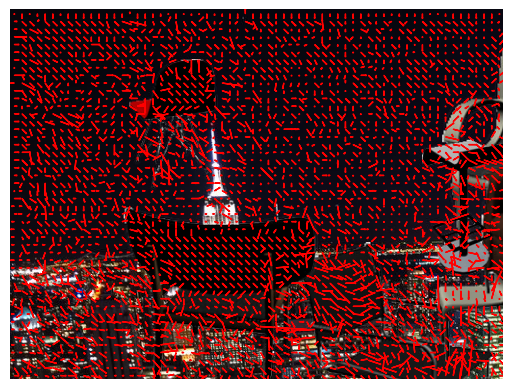

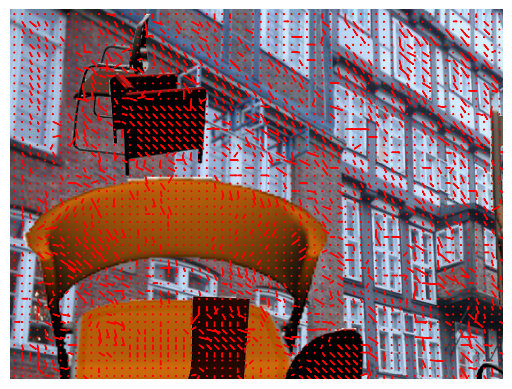

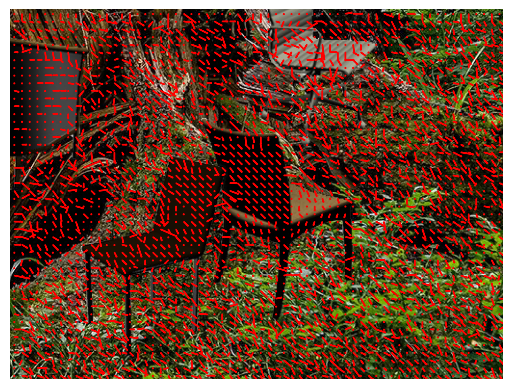

In [168]:
mvs_diam = []
for i in range(3):
  mvs_diamond = diamond_search(D[i][0], D[i][1], 8)
  plot_motion_vectors(D[i][0], mvs_diamond, 8)
  mvs_diam.append(mvs_diamond)

In [169]:
for i in range(3):
  mvs_pix = pixel_mvs(mvs_diam[i], 8, D[i][0])
  px_arr = normalize_array(mvs_pix)
  error = np.mean(np.sqrt((px_arr - gts[i])**2))
  print(f"Mean Squared error for image {i}: {error}")

Mean Squared error for image 0: 4.222853527410165
Mean Squared error for image 1: 16.18079998588487
Mean Squared error for image 2: 27.952862638751828


##Three step search

In [114]:
import numpy as np

def three_step_search(ref_img, cur_img, block_size):
    height, width, channels = ref_img.shape
    block_half_size = block_size // 2
    search_range = 15  # Define the search range

    # Pad images to handle blocks at the edges
    padded_ref_img = np.pad(ref_img, block_half_size, mode='constant')
    padded_cur_img = np.pad(cur_img, block_half_size, mode='constant')

    # Initialize array to store motion vectors
    motion_vectors = np.zeros((height // block_size, width // block_size, 2))

    # Iterate over each block
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            # Extract block from reference image
            ref_block = padded_ref_img[i:i+block_size, j:j+block_size]

            # Initialize search center
            center = [0, 0]

            # Three-step search
            step_size = 4
            while step_size >= 1:
                min_cost = float('inf')
                best_motion = [0, 0]

                # Define search pattern for three-step search
                search_pattern = [[0, 0], [step_size, 0], [-step_size, 0],
                                  [0, step_size], [0, -step_size], [step_size, step_size], [-step_size, -step_size], [-step_size, step_size], [step_size, -step_size]]

                for m, n in search_pattern:
                    x, y = center[0] + m, center[1] + n

                    # Calculate the cost (e.g., Sum of Absolute Differences)
                    cur_block = padded_cur_img[i+x+block_half_size:i+x+block_half_size+block_size,
                                                j+y+block_half_size:j+y+block_half_size+block_size]
                    if ref_block.shape != cur_block.shape:
                      continue
                    cost = np.sum((ref_block - cur_block)**2, axis=(0,1,2))

                    # Update motion vector if cost is minimized
                    if cost < min_cost:
                        min_cost = cost
                        best_motion = [x, y]

                # Update search center for the next iteration
                center = best_motion
                step_size //= 2

            # Store motion vector for this block
            motion_vectors[i // block_size, j // block_size] = best_motion

    return motion_vectors


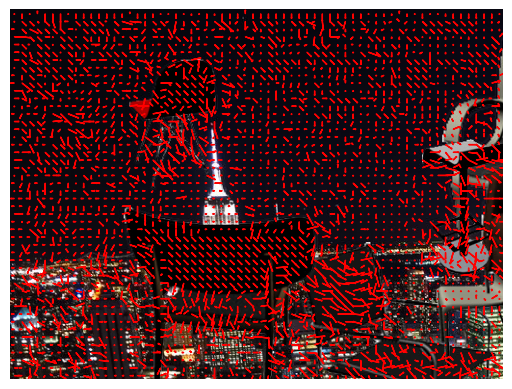

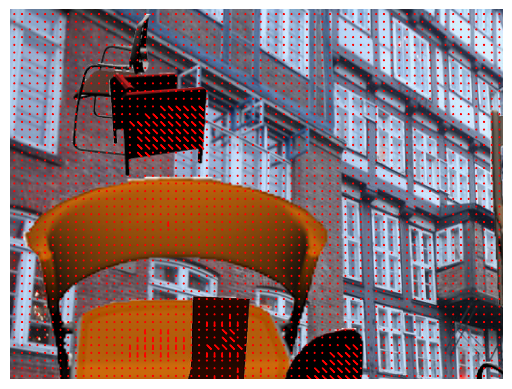

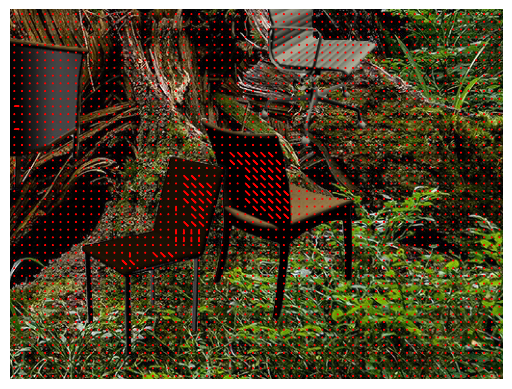

In [172]:
mvs_three_step = []
for i in range(3):
  mvs_3step = three_step_search(D[i][0], D[i][1], 8)
  plot_motion_vectors(D[i][0], mvs_3step, 8)
  mvs_three_step.append(mvs_3step)

In [173]:
for i in range(3):
  mvs_pix = pixel_mvs(mvs_three_step[i], 8, D[i][0])
  px_arr = normalize_array(mvs_pix)
  error = np.mean(np.sqrt((px_arr - gts[i])**2))
  print(f"Mean Squared error for image {i}: {error}")

Mean Squared error for image 0: 3.803983165704775
Mean Squared error for image 1: 16.495196104224757
Mean Squared error for image 2: 27.212247744950847
